Dataset Source: House Prices (Kaggle)


# End-to-End House Price Prediction Using Linear Regression in Python

This notebook demonstrates a complete workflow for predicting house prices using a real-world dataset. The process includes data cleaning, exploratory data analysis (EDA), feature engineering, model building, evaluation, and making predictions. All steps are performed using Python libraries such as pandas, seaborn, matplotlib, and scikit-learn.

**Key steps covered:**
- Data cleaning and preprocessing
- Exploratory Data Analysis (EDA) with visualizations
- Outlier detection
- Feature engineering
- Model building (Linear Regression, Ridge Regression)
- Model evaluation and comparison
- Model saving/loading
- Example predictions

## 1. Import Required Libraries

In [951]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

## 2. Load the Dataset

In [952]:
df = pd.read_csv('house_prices.csv')

In [953]:
df.head()

,house_id,size_sqft,bedrooms,age,distance_city_km,price
0,1,2900.0,1,68.0,43.67,374635.51
1,2,3243.0,5,60.0,32.22,464395.45
2,3,587.0,6,1.0,19.33,135920.06
3,4,3492.0,3,26.0,25.38,510385.77
4,5,3639.0,3,37.0,19.51,550330.20


### Initial Data Overview

In [954]:
df.describe()

,house_id,age,distance_city_km,price
count,102000.000000,100988.000000,100981.000000,100981.000000
mean,49974.714059,31.962322,24.907452,317280.174841
std,28869.219702,21.642496,14.432390,164080.976818
min,1.000000,-5.000000,0.000000,-109030.040000
25%,24965.750000,13.000000,12.370000,180978.390000
50%,49977.500000,32.000000,24.910000,318307.200000
75%,74967.250000,51.000000,37.380000,455852.440000
max,100000.000000,69.000000,50.000000,678761.310000


In [955]:
df.isnull().sum()

house_id               0
size_sqft           2006
bedrooms            1507
age                 1012
distance_city_km    1019
price               1019
dtype: int64

In [956]:
df.duplicated().sum()

1926

In [957]:
df = df.drop_duplicates()

In [958]:
df.shape

(100074, 6)

In [959]:
df.isnull().sum()

house_id               0
size_sqft           1978
bedrooms            1483
age                 1000
distance_city_km    1000
price               1001
dtype: int64

In [960]:
df = df.dropna(subset=['price'])

In [961]:
df.isnull().sum()

house_id               0
size_sqft           1965
bedrooms            1469
age                  988
distance_city_km     987
price                  0
dtype: int64

In [962]:
if 'house_id' in df.columns:
    df.drop('house_id', axis=1, inplace=True)
df.head()

,size_sqft,bedrooms,age,distance_city_km,price
0,2900.0,1,68.0,43.67,374635.51
1,3243.0,5,60.0,32.22,464395.45
2,587.0,6,1.0,19.33,135920.06
3,3492.0,3,26.0,25.38,510385.77
4,3639.0,3,37.0,19.51,550330.20


### Data Cleaning: Type Conversion & Consistency

In [963]:
# Fixed possible string values in bedrooms
df.loc[df['bedrooms'] == 'three', 'bedrooms'] = '3'

In [964]:
df['bedrooms'] = df['bedrooms'].astype(float)
df['age'] = df['age'].astype(str).str.replace('-', '').astype(float)
df['distance_city_km'] = df['distance_city_km'].astype(float)
df['price'] = df['price'].astype(str).str.replace('-', '').astype(float)
df['size_sqft'] = df['size_sqft'].astype(str).str.replace(',', '').astype(float)

### Handle Missing Values

In [965]:
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df['age'].fillna(df['age'].median(), inplace=True)
df['size_sqft'].fillna(method='ffill', inplace=True)
df['distance_city_km'].interpolate(method='nearest', inplace=True)
df = df.fillna(df.median(numeric_only=True))

C:\Users\apoor\AppData\Local\Temp\ipykernel_71020\1472581946.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
C:\Users\apoor\AppData\Local\Temp\ipykernel_71020\1472581946.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

## 3. Outlier Detection and Visualization

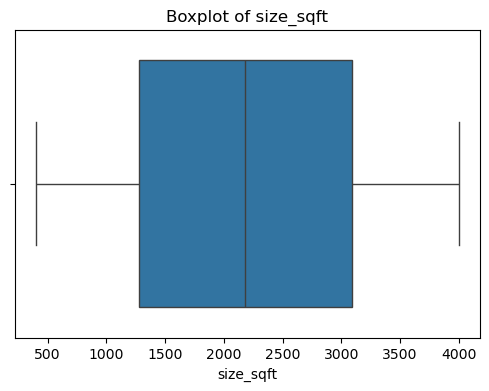

Outliers in size_sqft: 0


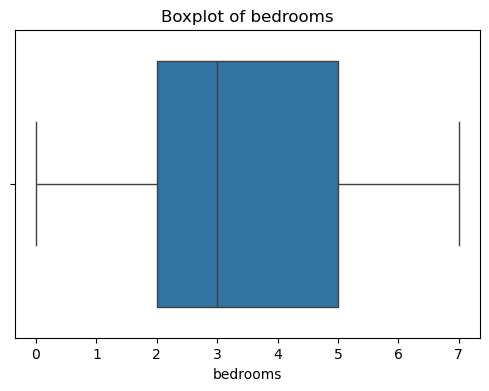

Outliers in bedrooms: 0


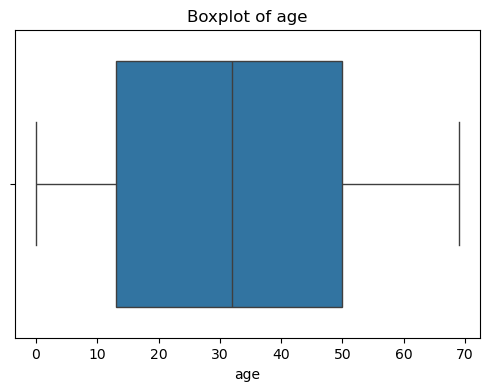

Outliers in age: 0


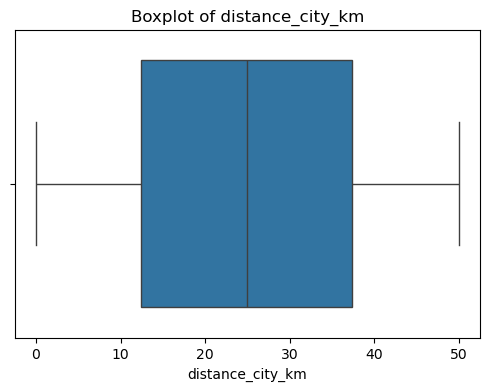

Outliers in distance_city_km: 0


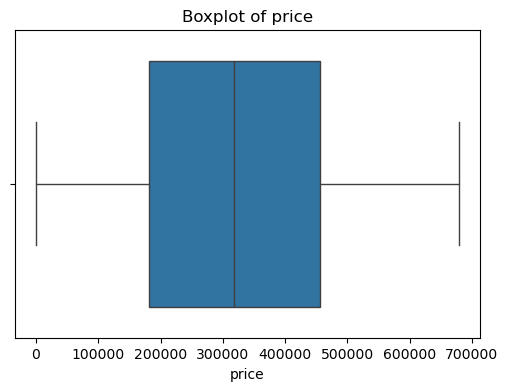

Outliers in price: 0


In [966]:
# Boxplots and outlier count for each numeric column
for col in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
    print(f"Outliers in {col}: {len(outliers)}")

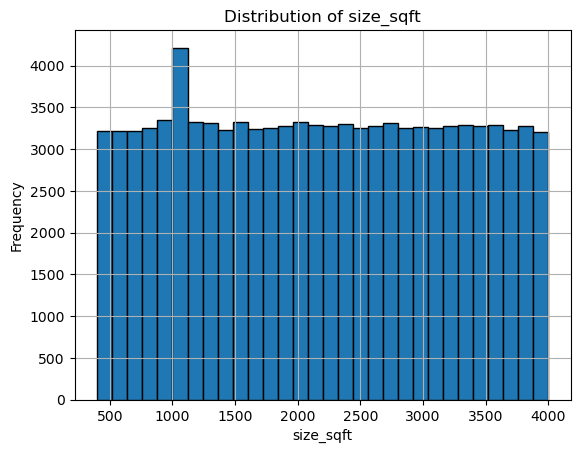

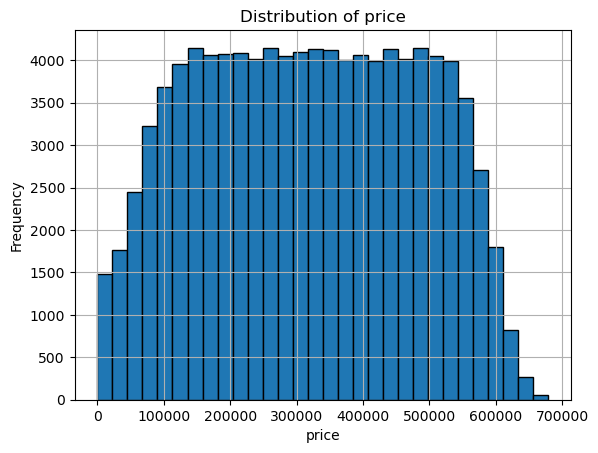

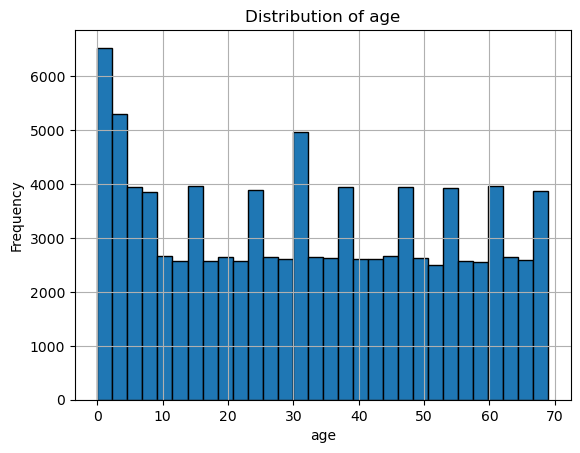

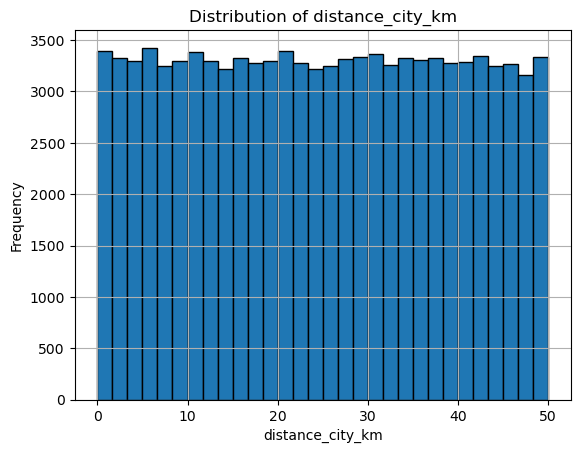

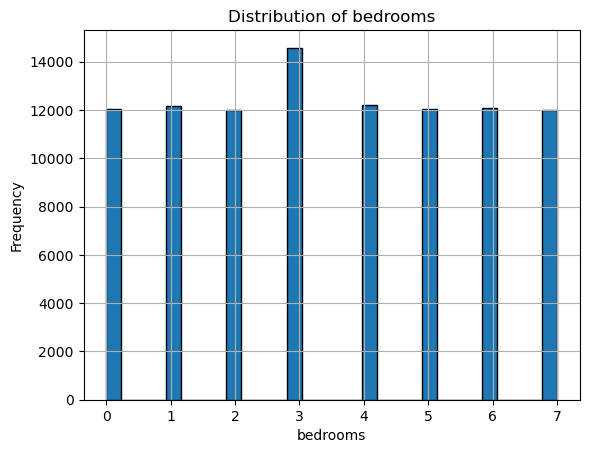

In [967]:
# Histograms for main features
for col in ['size_sqft', 'price', 'age', 'distance_city_km', 'bedrooms']:
    df[col].hist(bins=30, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## 4. Feature Engineering

In [968]:
# Price per square foot
df['price_per_sqft'] = df['price'] / df['size_sqft']
# Age bucket creation
df['age_bucket'] = pd.cut(df['age'], bins=[0, 10, 30, 100], labels=['New', 'Mid', 'Old'])
# Encode age bucket
df = pd.get_dummies(df, columns=['age_bucket'], drop_first=True)
df.head()

,size_sqft,bedrooms,age,distance_city_km,price,price_per_sqft,age_bucket_Mid,age_bucket_Old
0,2900.0,1.0,68.0,43.67,374635.51,129.184659,False,True
1,3243.0,5.0,60.0,32.22,464395.45,143.199337,False,True
2,587.0,6.0,1.0,19.33,135920.06,231.550358,False,False
3,3492.0,3.0,26.0,25.38,510385.77,146.158582,True,False
4,3639.0,3.0,37.0,19.51,550330.20,151.231162,False,True


## 5. Data Preparation

Split the data into train and test sets and scale the features.

In [969]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [970]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Feature Exploration & Visualization

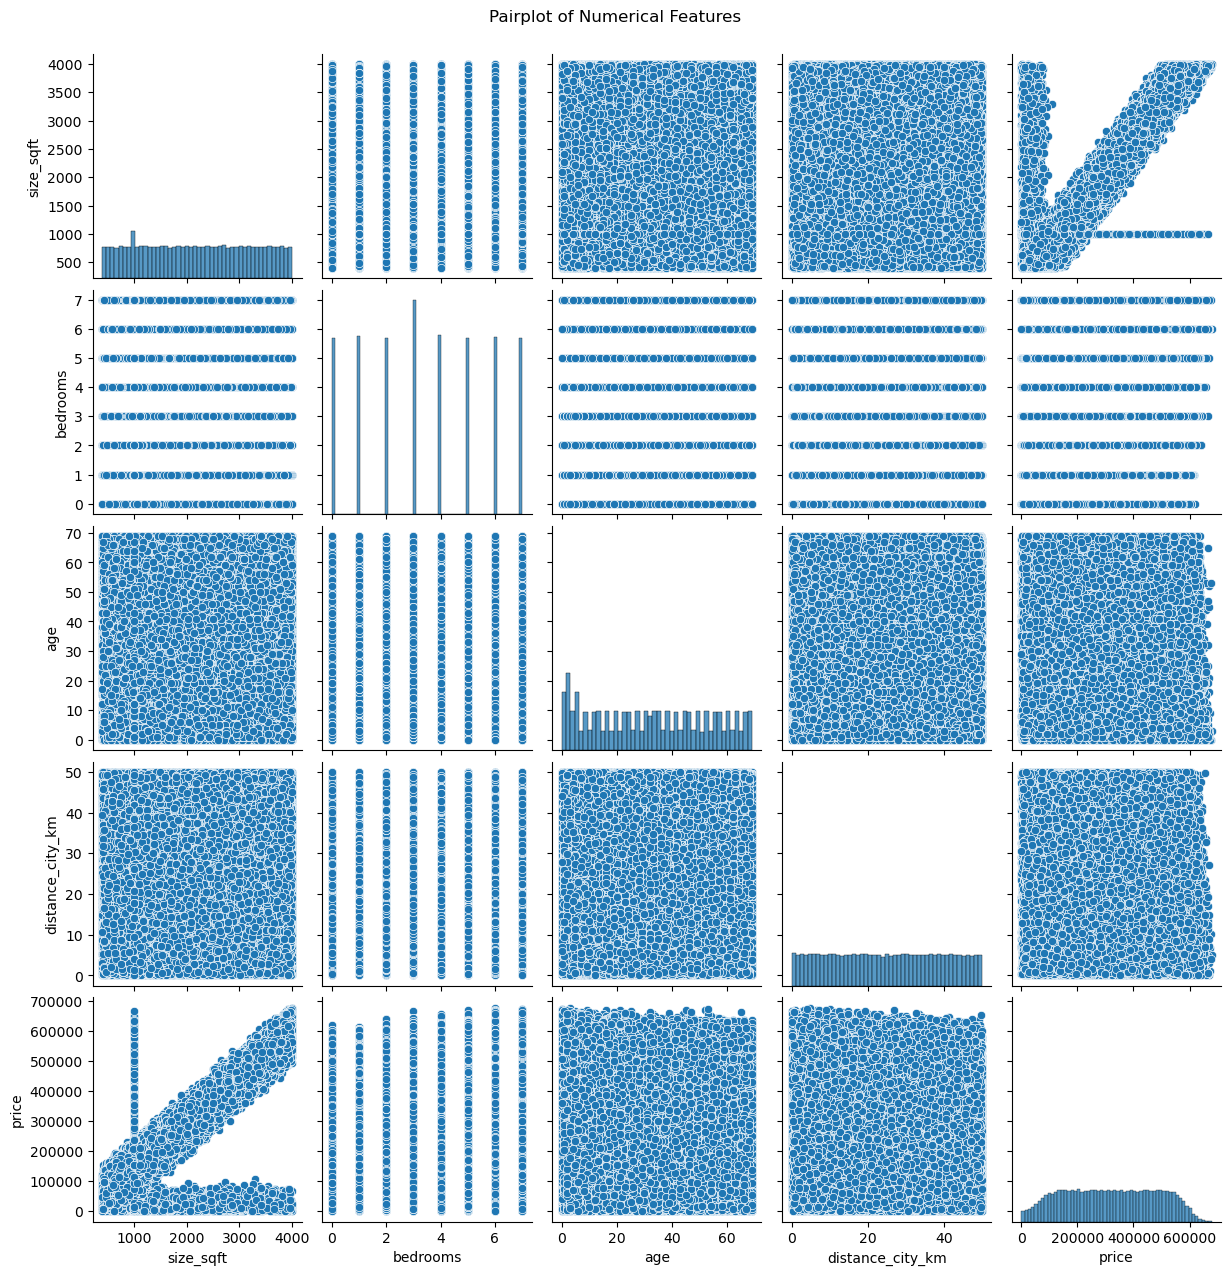

In [971]:
sns.pairplot(df[['size_sqft', 'bedrooms', 'age', 'distance_city_km', 'price']])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

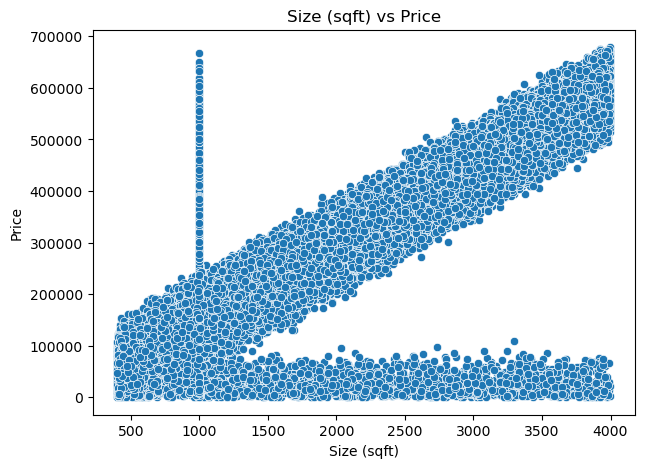

In [972]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='size_sqft', y='price', data=df)
plt.title('Size (sqft) vs Price')
plt.xlabel('Size (sqft)')
plt.ylabel('Price')
plt.show()

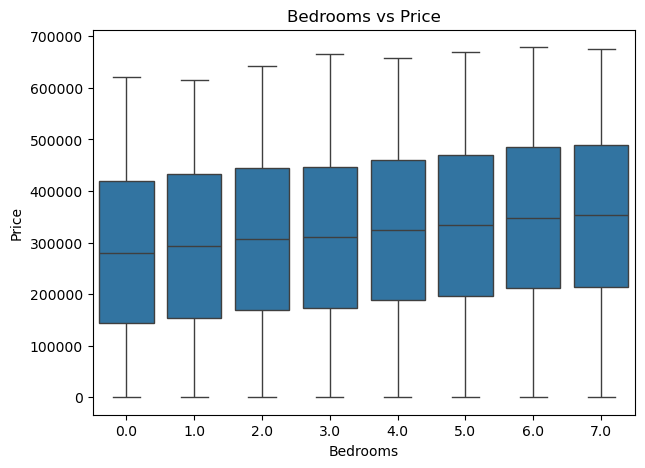

In [973]:
plt.figure(figsize=(7,5))
sns.boxplot(x='bedrooms', y='price', data=df)
plt.title('Bedrooms vs Price')
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

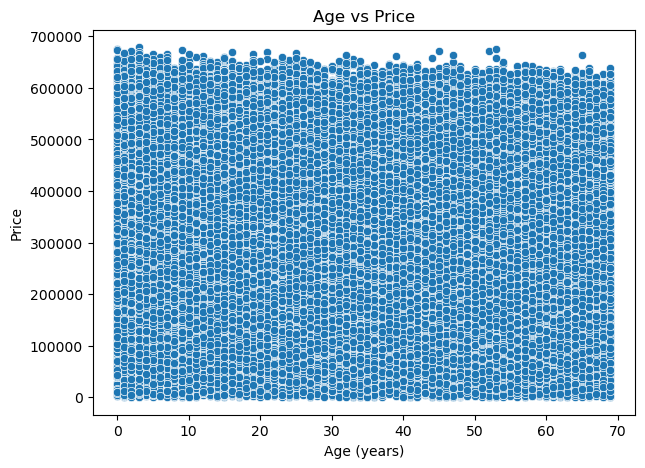

In [974]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='age', y='price', data=df)
plt.title('Age vs Price')
plt.xlabel('Age (years)')
plt.ylabel('Price')
plt.show()

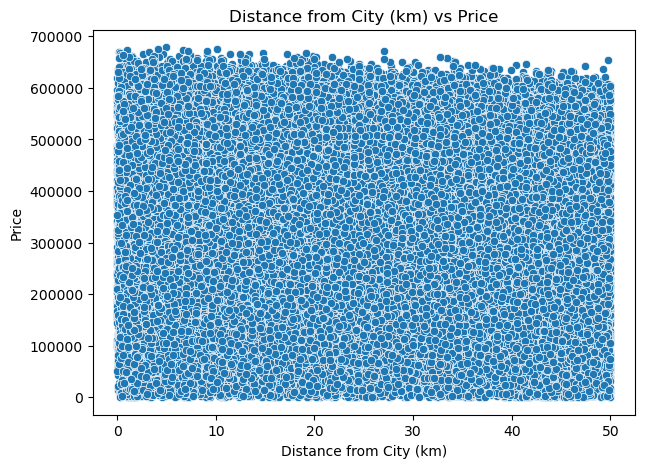

In [975]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='distance_city_km', y='price', data=df)
plt.title('Distance from City (km) vs Price')
plt.xlabel('Distance from City (km)')
plt.ylabel('Price')
plt.show()

### Insights from Visualizations

- **Size (sqft) vs Price:** There is a positive correlation; larger houses tend to have higher prices.
- **Bedrooms vs Price:** Houses with more bedrooms generally have higher prices, but there are outliers.
- **Age vs Price:** Newer houses (lower age) tend to be more expensive, but the relationship is not strictly linear.
- **Distance from City vs Price:** Houses closer to the city center are generally more expensive.
- **Pairplot:** Most features show some correlation with price, especially size and bedrooms.

## 7. Model Building: Linear Regression

In [976]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
# Save model
joblib.dump(lr, 'linear_regression_model.joblib')
# Load model
lr_loaded = joblib.load('linear_regression_model.joblib')

## 8. Model Building: Ridge Regression

In [977]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
# Save model
joblib.dump(ridge, 'ridge_regression_model.joblib')
# Load model
ridge_loaded = joblib.load('ridge_regression_model.joblib')
y_pred_ridge = ridge.predict(X_test_scaled)

## 9. Model Evaluation & Comparison

In [978]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Linear Regression
y_pred_lr = lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Ridge Regression
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print('Linear Regression:')
print(f'MSE: {mse_lr:.2f}, RMSE: {rmse_lr:.2f}, MAE: {mae_lr:.2f}, R2: {r2_lr:.2f}')
print('Ridge Regression:')
print(f'MSE: {mse_ridge:.2f}, RMSE: {rmse_ridge:.2f}, MAE: {mae_ridge:.2f}, R2: {r2_ridge:.2f}')

Linear Regression:
MSE: 1116961298.24, RMSE: 33420.97, MAE: 15759.75, R2: 0.96
Ridge Regression:
MSE: 1116960468.20, RMSE: 33420.96, MAE: 15759.90, R2: 0.96


### Model Comparison Insights

- Compared the metrics above to see which model performs better.
- Ridge Regression helps prevent overfitting and can be more robust if features are correlated.
- We can choose the model with the best trade-off between interpretability and performance for our use case.

## 10. Prediction Example

Predict the price of a house given new input features.

In [979]:
# Example input (ensuring the order matches the X columns after get_dummies)
input_1 = [1500, 3, 5, 8, 0.004370, False, True]  # Example input with one-hot encoded age bucket
input_scaled = scaler.transform([input_1])
predicted_price = lr.predict(input_scaled)
print(f"Predicted price: {predicted_price}")

Predicted price: [42320.56392535]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## 12. Single Feature Regression Example

Predicting house price using only the size_sqft feature.

In [980]:
X = df[['size_sqft']]
y = df['price']

X_train_1 , X_test_1, y_train_1, y_test_1 = train_test_split(X,y, test_size=0.2, random_state= 42)

In [981]:
X_train_scaled_1 = scaler.fit_transform(X_train_1)
X_test_scaled_1 = scaler.transform(X_test_1)

In [982]:
from sklearn.linear_model import LinearRegression

lr_1 = LinearRegression()
lr_1.fit(X_train_scaled_1,y_train_1)

LinearRegression()

In [983]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


y_pred_1 =lr_1.predict(X_test_scaled_1)

mse_1 = mean_squared_error(y_test_1, y_pred_1)
r2_1 = r2_score(y_test_1, y_pred_1)

mae_1 = mean_absolute_error(y_test_1, y_pred_1)
rmse_1 = np.sqrt(mse_1)


print("MSE:", mse_1)
print("R² Score:", r2_1)
print("MAE:", mae_1)
print("RMSE:", rmse_1)


MSE: 3801289495.409636
R² Score: 0.8563628341825895
MAE: 34120.24776096694
RMSE: 61654.59833142728


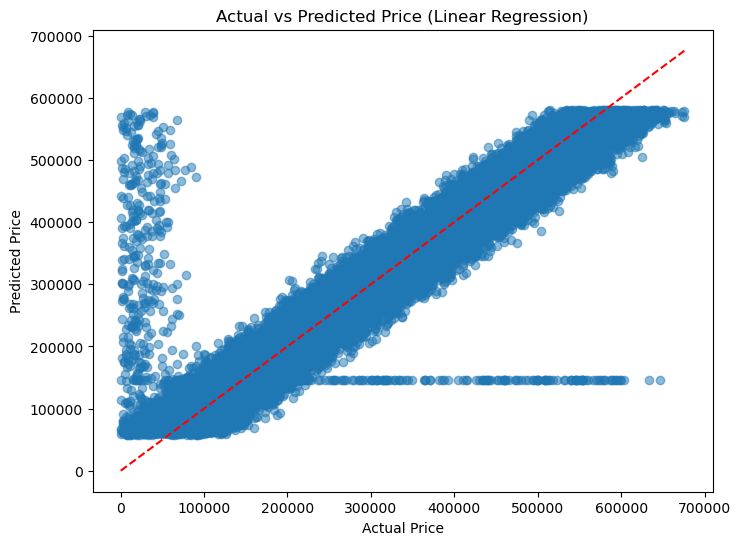

In [984]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_1, y_pred_1, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (Linear Regression)")
plt.plot([y_test_1.min(), y_test_1.max()], [y_test_1.min(), y_test_1.max()], color='red', linestyle='--')
plt.show()

In [985]:
input_1 = [1500] 

input_scaled = scaler.transform([input_1])

predicted_price = lr_1.predict(input_scaled)

print(f"Predicted price: {predicted_price}")

Predicted price: [217954.25004805]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Why do Linear Regression and Ridge Regression give similar metrics?

- Both models are linear and will perform similarly if the dataset does not have strong multicollinearity or overfitting issues.
- Ridge Regression only regularizes the coefficients, so if the data is already well-behaved, the improvement may be minimal.
- To see a bigger difference, we can try increasing the regularization strength (`alpha`) or use a more complex model.

**Should you use only one model?**
- It's best practice to compare multiple models to find the best fit for your data.
- We can try non-linear models like Random Forest, Gradient Boosting, or XGBoost for comparison.

## 9.1. Model Building: Random Forest Regression

In [986]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

In [987]:
# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print('Random Forest Regression:')
print(f'MSE: {mse_rf:.2f}, RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R2: {r2_rf:.2f}')

Random Forest Regression:
MSE: 373816.45, RMSE: 611.41, MAE: 326.20, R2: 1.00


### Model Comparison Summary

- If all models give similar results, your data may be easy to model or lack complexity.
- If Random Forest (or another non-linear model) performs better, it suggests non-linear relationships exist in your data.
- Always compare at least two models for a robust solution.

## 9.2. Feature Importance Calculation

Feature importance helps us understand which features most influence the model's predictions. For tree-based models like Random Forest, we can directly extract feature importances. For linear models, coefficients can be interpreted as importance (after scaling).

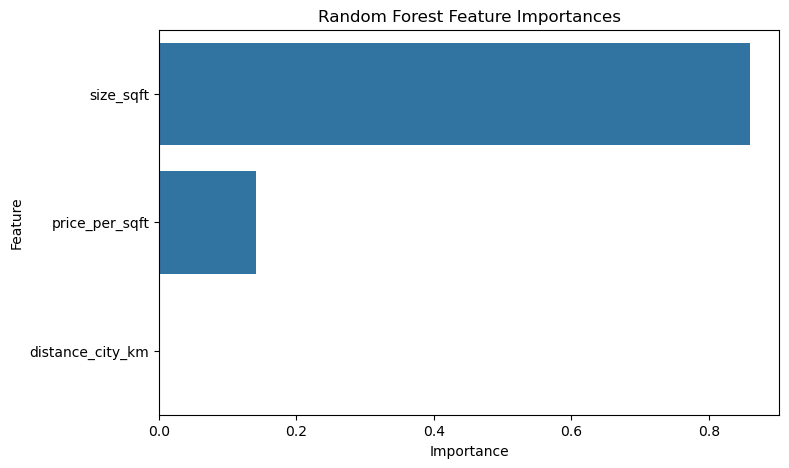

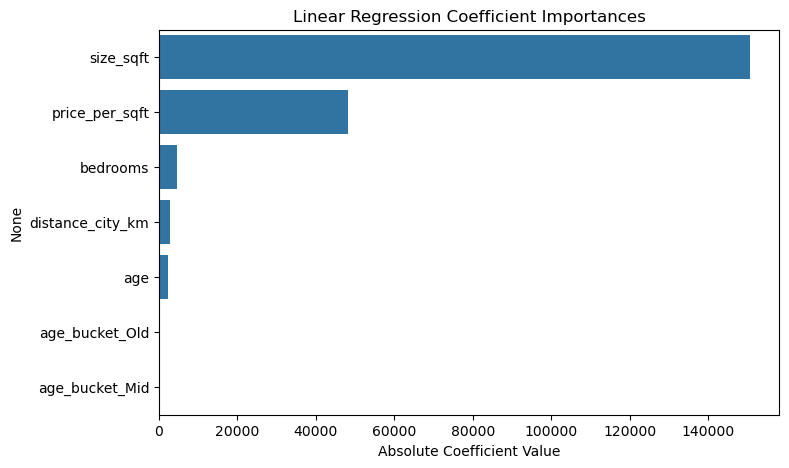

In [989]:
# Feature importance from Random Forest
importances = rf.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(3))
plt.title('Random Forest Feature Importances')
plt.show()

# For linear models (coefficients)
coef_lr = pd.Series(lr.coef_, index=feature_names)
coef_lr = coef_lr.abs().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=coef_lr.values, y=coef_lr.index)
plt.title('Linear Regression Coefficient Importances')
plt.xlabel('Absolute Coefficient Value')
plt.show()

### Model Comparison Summary

- If all models give similar results, your data may be easy to model or lack complexity.
- If Random Forest (or another non-linear model) performs better, it suggests non-linear relationships exist in your data.
- Always compare at least two models for a robust solution.